In [1]:
import pandas as pd 
import numpy as np 
import datetime
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline
# import zigzag
import plotly.express as px
import plotly.graph_objects as go

# Get BTC Data 15 min

In [2]:
df = pd.read_csv("BTC_Close.csv", index_col=0)
df.index = pd.to_datetime(df.index, unit='ms')
data = df.resample('15T').last()

In [3]:
# def plot_pivots(X, pivots, ax=None):
#     if ax:
#         # ax.ylim(X.min()*0.99, X.max()*1.01)
#         ax.plot(X, 'k:', alpha=0.5)
#         ax.plot(X[pivots != 0], 'k-')
#         ax.scatter(X[pivots == 1].index, X[pivots == 1], color='g')
#         ax.scatter(X[pivots == -1].index, X[pivots == -1], color='r')
#         return
        
#     plt.figure(figsize=(20, 10))
#     # plt.xlim(0, len(X))
#     plt.ylim(X.min()*0.99, X.max()*1.01)
#     plt.plot(X, 'k:', alpha=0.5)
#     plt.plot(X[pivots != 0], 'k-')
#     plt.scatter(X[pivots == 1].index, X[pivots == 1], color='g')
#     plt.scatter(X[pivots == -1].index, X[pivots == -1], color='r')


"""
reference:
https://github.com/jbn/ZigZag.git
"""
import numpy as np

PEAK = 1
VALLEY = -1


def identify_initial_pivot(X, up_thresh, down_thresh):
    x_0 = X[0]
    x_t = x_0

    max_x = x_0
    min_x = x_0

    max_t = 0
    min_t = 0

    up_thresh += 1
    down_thresh += 1

    for t in range(1, len(X)):
        x_t = X[t]

        if x_t / min_x >= up_thresh:
            return VALLEY if min_t == 0 else PEAK

        if x_t / max_x <= down_thresh:
            return PEAK if max_t == 0 else VALLEY

        if x_t > max_x:
            max_x = x_t
            max_t = t

        if x_t < min_x:
            min_x = x_t
            min_t = t

    t_n = len(X)-1
    return VALLEY if x_0 < X[t_n] else PEAK


def peak_valley_pivots(X, up_thresh, down_thresh):
    """
    Find the peaks and valleys of a series.

    :param X: the series to analyze
    :param up_thresh: minimum relative change necessary to define a peak
    :param down_thesh: minimum relative change necessary to define a valley
    :return: an array with 0 indicating no pivot and -1 and 1 indicating
        valley and peak


    The First and Last Elements
    ---------------------------
    The first and last elements are guaranteed to be annotated as peak or
    valley even if the segments formed do not have the necessary relative
    changes. This is a tradeoff between technical correctness and the
    propensity to make mistakes in data analysis. The possible mistake is
    ignoring data outside the fully realized segments, which may bias
    analysis.
    """
    if down_thresh > 0:
        raise ValueError('The down_thresh must be negative.')

    initial_pivot = identify_initial_pivot(X, up_thresh, down_thresh)
    t_n = len(X)
    pivots = np.zeros(t_n, dtype=np.int_)
    trend = -initial_pivot
    last_pivot_t = 0
    last_pivot_x = X[0]

    pivots[0] = initial_pivot

    # Adding one to the relative change thresholds saves operations. Instead
    # of computing relative change at each point as x_j / x_i - 1, it is
    # computed as x_j / x_1. Then, this value is compared to the threshold + 1.
    # This saves (t_n - 1) subtractions.
    up_thresh += 1
    down_thresh += 1

    for t in range(1, t_n):
        x = X[t]
        r = x / last_pivot_x

        if trend == -1:
            if r >= up_thresh:
                pivots[last_pivot_t] = trend # 上一个被标记为谷底的点
                trend = PEAK
                last_pivot_x = x
                last_pivot_t = t
            elif x < last_pivot_x:
                last_pivot_x = x
                last_pivot_t = t
        else:
            if r <= down_thresh:
                pivots[last_pivot_t] = trend
                trend = VALLEY
                last_pivot_x = x
                last_pivot_t = t
            elif x > last_pivot_x:
                last_pivot_x = x
                last_pivot_t = t

    if last_pivot_t == t_n-1:
        pivots[last_pivot_t] = trend # 新趋势
    elif pivots[t_n-1] == 0:
        pivots[t_n-1] = -trend # 老趋势

    return pivots


def max_drawdown(X):
    """
    Compute the maximum drawdown of some sequence.

    :return: 0 if the sequence is strictly increasing.
        otherwise the abs value of the maximum drawdown
        of sequence X
    """
    mdd = 0
    peak = X[0]

    for x in X:
        if x > peak:
            peak = x

        dd = (peak - x) / peak

        if dd > mdd:
            mdd = dd

    return mdd if mdd != 0.0 else 0.0


def pivots_to_modes(pivots):
    """
    Translate pivots into trend modes.

    :param pivots: the result of calling ``peak_valley_pivots``
    :return: numpy array of trend modes. That is, between (VALLEY, PEAK] it
    is 1 and between (PEAK, VALLEY] it is -1.
    """

    modes = np.zeros(len(pivots), dtype=np.int_)
    mode = -pivots[0]

    modes[0] = pivots[0]

    for t in range(1, len(pivots)):
        x = pivots[t]
        if x != 0:
            modes[t] = mode
            mode = -x
        else:
            modes[t] = mode

    return modes


def compute_segment_returns(X, pivots):
    """
    :return: numpy array of the pivot-to-pivot returns for each segment."""
    pivot_points = np.array(X[pivots != 0])
    return pivot_points[1:] / pivot_points[:-1] - 1.0

In [4]:
X = data["Close"].loc["2022"]
rise = 0.05

## 回测

In [5]:
# TODO: 加上均线
def backtest(X, rise, output=True):
    # pivots = peak_valley_pivots(X, rise, -rise)
    allowance = 10000
    cash = 0
    shares = 0
    low = None
    high = None
    n = len(X)
    cash_array = np.zeros(n)
    shares_array = np.zeros(n)
    actions = np.zeros(n)
    up_thresh, down_thresh = rise, -rise
    for i in range(n):
        if i == 0:
            initial_pivot = identify_initial_pivot(X[:100], up_thresh, down_thresh) # 这个会数据泄漏
            t_n = len(X)
            pivots = np.zeros(t_n, dtype=np.int_)
            trend = -initial_pivot
            last_pivot_t = 0
            last_pivot_x = X[0]

            pivots[0] = initial_pivot
            up_thresh += 1
            down_thresh += 1
            continue
        
        t = i
        x = X[t]
        r = x / last_pivot_x

        if trend == -1:
            if r >= up_thresh: # 如果上升幅度超过阈值，则标记上个点为谷底
                pivots[last_pivot_t] = trend # 上一个被标记为谷底的点
                low = last_pivot_x
                trend = PEAK
                last_pivot_x = x
                last_pivot_t = t
            elif x < last_pivot_x:
                last_pivot_x = x
                last_pivot_t = t
        else:
            if r <= down_thresh: # 如果下降幅度超过阈值，则标记上个点为顶点
                pivots[last_pivot_t] = trend
                high = last_pivot_x
                trend = VALLEY
                last_pivot_x = x
                last_pivot_t = t
            elif x > last_pivot_x:
                last_pivot_x = x
                last_pivot_t = t   
                
        # if last_pivot_t == t_n-1:
        #     pivots[last_pivot_t] = trend # 新趋势
        # elif pivots[t_n-1] == 0:
        #     pivots[t_n-1] = -trend # 老趋势
            
        p = X[i] # 当前价格
        
        # if pivots[i] == -1:
        #     low = p
            
        # if pivots[i] == 1:
        #     high = p
            
        if low is None or high is None: # 确保已经有了low high
            continue

        if p < low and shares >= 0: # and p < high * (1-rise) # TODO: 增加频率，避免一下子跌太多，错过做空时机
            # 做空
            shares = -allowance / p
            cash += allowance
            if output: print("做空", p, X.index[i])
            actions[i] = -1
            
        if (p > high) and shares < 0: # and p > low * (1 + rise)
        # if (p > (0.5 * low + 0.5 * high)) and shares < 0: # 特殊止损条件
            # 平仓止损
            cash += shares * p
            if output: print("止损", p, X.index[i], "盈亏", allowance + shares * p)
            shares = 0
            actions[i] = -2
        
        # if (p < 0.9 * low) and shares < 0:
        #     # 止盈
        #     cash += shares * p
        #     shares = 0
        #     if output: print("止盈", p, X.index[i])
            
        if i == len(pivots) - 1: # 最后时刻清仓
            cash += shares * p
            shares = 0
        
        cash_array[i] = cash
        shares_array[i] = shares
    
    ## 计算收益
    df_pnl = pd.DataFrame({"cash": cash_array, "shares": shares_array, "price": X, "pivots": pivots, "actions": actions})
    df_pnl.index = X.index
    df_pnl["pnl"] = df_pnl["cash"] + df_pnl["shares"] * df_pnl["price"]
    
    # 计算收益率等参数
    df_pnl["ret"] = df_pnl["pnl"].diff().fillna(0) / allowance
    rets = df_pnl.loc[df_pnl["ret"] != 0, "ret"]
    freq = (rets.index[1] - rets.index[0]).total_seconds() // 60
    time_length = rets.shape[0] * ((rets.index[1] - rets.index[0]).total_seconds() / 3600 / 24 / 365)
    total_return = df_pnl["pnl"][-1] / allowance
    yearly_return = total_return / time_length
    yearly_vol = df_pnl["ret"].std() * np.sqrt(4 * 24 * 365)
    maxdrawdown = max(rets.cumsum().cummax() - rets.cumsum())
    stats = dict(rise=rise, freq=freq, total_return=total_return, yearly_vol=yearly_vol, maxdrawdown=maxdrawdown, hold_time=time_length, start_date=X.index[0].date(), end_date=X.index[-1].date())
    # stats = [rise, total_return, yearly_vol, maxdrawdown]
    return df_pnl, pivots, actions, stats
        

In [14]:
freq = 25
rise = 0.05
start_date = "2020"
data = df.resample(f'{freq}T').last()
X = data["Close"].loc[start_date:]
df_pnl, pivots, actions, stats = backtest(X, rise, False)

display(pd.DataFrame([stats]))
## 绘图
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(25, 20), sharex=True)
ax1.plot(df_pnl[["pnl"]])
ax1.legend(["累计盈亏"])
ax2.plot(X, 'k:', alpha=0.5)
ax2.plot(X[pivots != 0], 'k-')
ax2.scatter(X[pivots == 1].index, X[pivots == 1], color='g')
ax2.scatter(X[pivots == -1].index, X[pivots == -1], color='r')
for i in range(len(X[actions != 0]) // 2):
    ax2.plot(X[actions != 0][i*2:i*2+2], 'm-')
# ax2.scatter(X[actions == -1].index, X[actions == -1], color='b', s=100)
# ax2.scatter(X[actions == -2].index, X[actions == -2], color='purple', s=100)
# plot_pivots(X, pivots, ax=ax2)
fig.suptitle(f"涨跌幅为{rise:.2%}的15分钟之字转向盈利图")
ax2.legend(["之字转向图"])

In [7]:
stats

{'rise': 0.05,
 'freq': 25.0,
 'total_return': 0.20757438692569757,
 'yearly_vol': 0.6622818818154433,
 'maxdrawdown': 1.0865664110056592,
 'hold_time': 1.0379090563165907,
 'start_date': datetime.date(2020, 1, 1),
 'end_date': datetime.date(2022, 7, 31)}

## 制作一个表格计算收益，回撤，波动率，夏普，入场时间等元素

In [8]:
stats_list = []

In [9]:
def run_backtest(rise):
    df_pnl, pivots, actions, stats = backtest(X, rise, False)
    display(pd.DataFrame([stats]))
    stats_list.append(stats)
    print("Good")


In [13]:
run_backtest(0.1)

,rise,freq,total_return,yearly_vol,maxdrawdown,hold_time,start_date,end_date
0,0.1,25.0,-0.462134,0.611761,1.539501,0.630089,2020-01-01,2022-07-31


Good


1

In [10]:
from concurrent.futures import ProcessPoolExecutor
with ProcessPoolExecutor(max_workers=2) as executor:
    executor.map(run_backtest, [0.1,0.2])

In [11]:
stats_list

[]

In [ ]:
# data = df.resample('T').last()
# X = data["Close"].loc["2022":]
for freq in [1,2,5,10,15,20,25,30]:
    data = df.resample(f'{freq}T').last()
    X = data["Close"].loc["2020":]
    for rise in [0.0001, 0.001] + np.arange(0.01, 0.2, 0.01).tolist():
        df_pnl, pivots, actions, stats = backtest(X, rise, output=False)
        display(pd.DataFrame([stats]))
        stats_list.append(stats)


In [89]:
df_stats = pd.DataFrame(stats_list)
df_stats.sort_values("total_return", ascending=False).to_csv("zigzag_rank.csv", index=False)

In [12]:
import multiprocessing

multiprocessing.cpu_count()

20

In [50]:
pd.set_option('display.max_rows', None)
df_stats.sort_values(by='rise')

,rise,freq,total_return,yearly_vol,maxdrawdown,hold_time,start_date,end_date
0,0.0001,1.0,0.781530,0.131702,0.269425,0.292890,2022-01-01,2022-07-31
21,0.0001,2.0,-0.239270,0.189611,0.477401,0.291008,2022-01-01,2022-07-31
105,0.0001,20.0,0.209758,0.590571,0.243004,0.288128,2022-01-01,2022-07-31
42,0.0001,5.0,0.310185,0.298902,0.281448,0.289355,2022-01-01,2022-07-31
84,0.0001,15.0,0.363293,0.510864,0.327070,0.295434,2022-01-01,2022-07-31
63,0.0001,10.0,0.199993,0.425982,0.445772,0.290240,2022-01-01,2022-07-31
126,0.0001,25.0,-0.013041,0.676660,0.354008,0.291381,2022-01-01,2022-07-31
22,0.0010,2.0,-0.025622,0.189922,0.432562,0.285681,2022-01-01,2022-07-31
85,0.0010,15.0,0.326228,0.513063,0.257315,0.288927,2022-01-01,2022-07-31
127,0.0010,25.0,0.231226,0.681494,0.300084,0.291239,2022-01-01,2022-07-31


## 超级高频交易 rise=0.001竟然收益不错

<AxesSubplot:xlabel='0'>

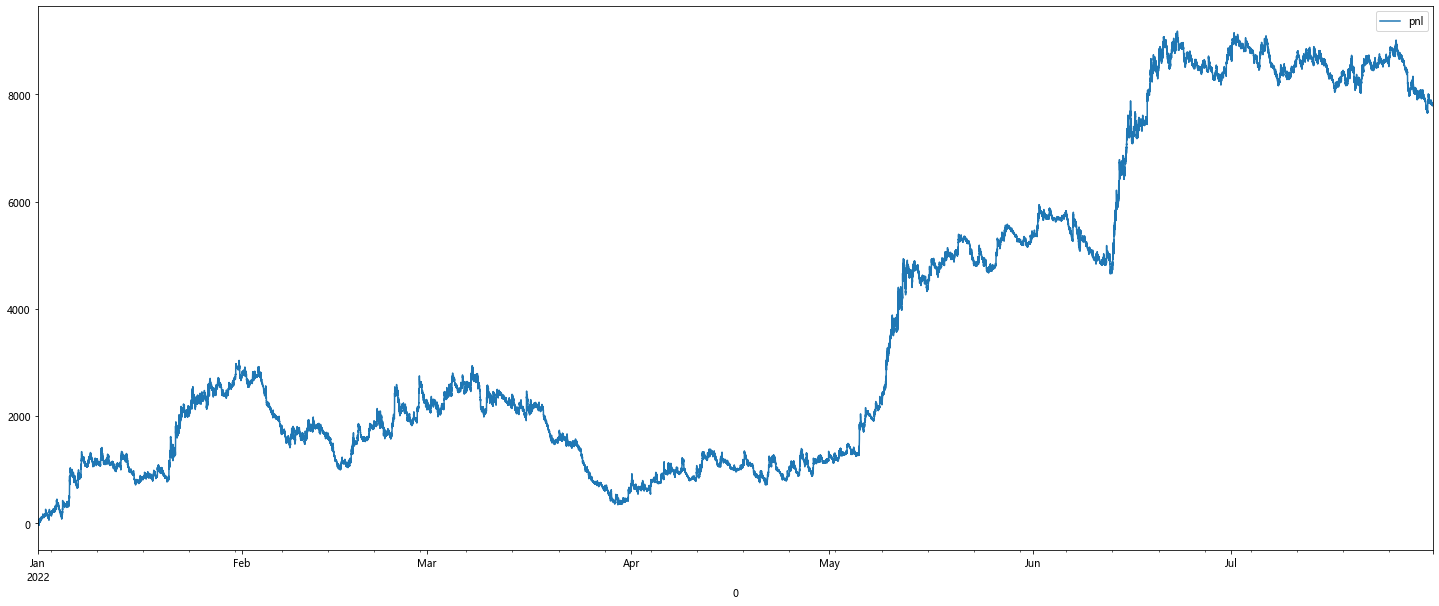

In [45]:
data = df.resample('T').last()
X = data["Close"].loc["2022":]
rise = 0.0001
df_pnl, pivots, actions, stats = backtest(X, rise, output=False)
df_pnl[['pnl']].plot(figsize=(25, 10))

<AxesSubplot:xlabel='0'>

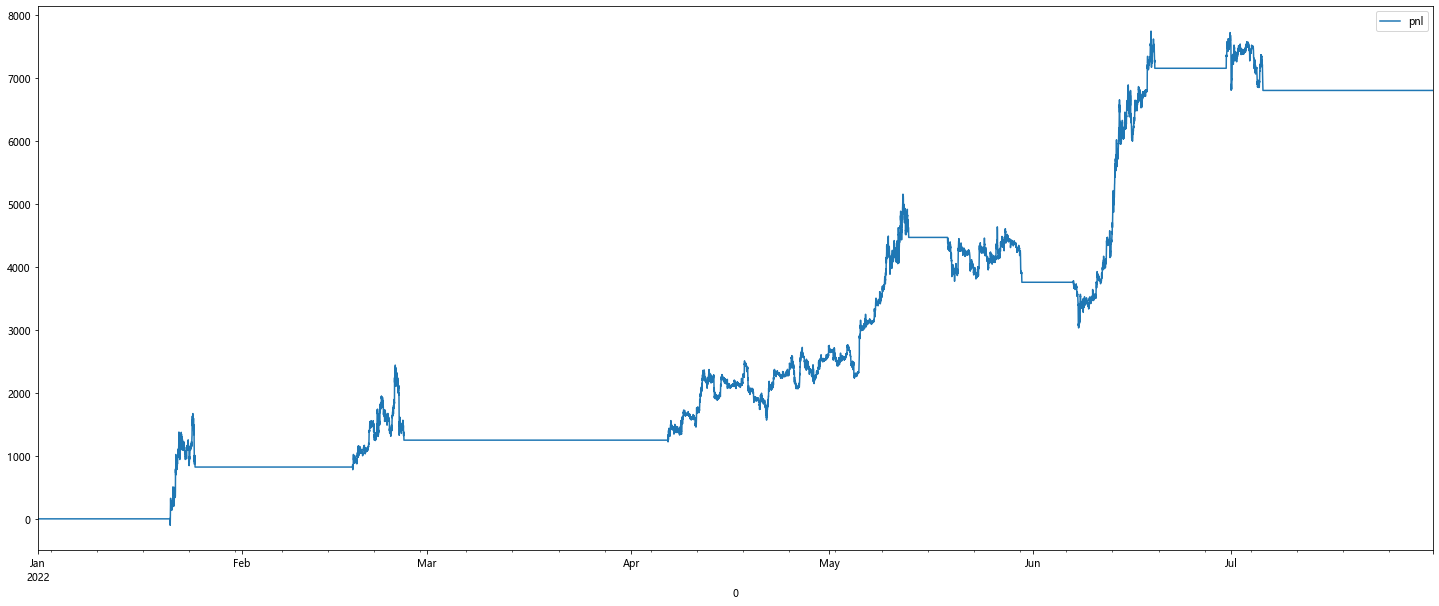

In [46]:
data = df.resample('10T').last()
X = data["Close"].loc["2022":]
rise = 0.06
df_pnl, pivots, actions, stats = backtest(X, rise, output=False)
df_pnl[['pnl']].plot(figsize=(25, 10))


In [ ]:

## 绘图
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(25, 20), sharex=True)
ax1.plot(df_pnl[["pnl"]])
ax1.legend(["累计盈亏"])
ax2.plot(X, 'k:', alpha=0.5)
ax2.plot(X[pivots != 0], 'k-')
ax2.scatter(X[pivots == 1].index, X[pivots == 1], color='g')
ax2.scatter(X[pivots == -1].index, X[pivots == -1], color='r')
for i in range(len(X[actions != 0]) // 2):
    ax2.plot(X[actions != 0][i*2:i*2+2], 'm-')
# ax2.scatter(X[actions == -1].index, X[actions == -1], color='b', s=100)
# ax2.scatter(X[actions == -2].index, X[actions == -2], color='purple', s=100)
# plot_pivots(X, pivots, ax=ax2)
fig.suptitle(f"涨跌幅为{rise:.2%}的15分钟之字转向盈利图")
ax2.legend(["之字转向图"])

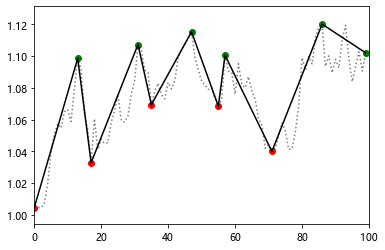

count  -1    43.000000
        1    56.000000
mean   -1    -0.004875
        1     0.005506
std    -1     0.009995
        1     0.009663
min    -1    -0.025602
        1    -0.018131
25%    -1    -0.011249
        1     0.000144
50%    -1    -0.005225
        1     0.004643
75%    -1     0.000075
        1     0.010315
max    -1     0.017768
        1     0.028133
dtype: float64
[ 0.09370263 -0.05981991  0.07204542 -0.03419711  0.04289563 -0.04197655
  0.03001853 -0.05506552  0.07707074 -0.016124  ]


In [11]:
import matplotlib
# matplotlib.use("TkAgg")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import pathlib
# sys.path.append("%s/zigzag" % pathlib.Path().absolute())
# from zigzag import zigzag


def plot_pivots(X, pivots):
    plt.xlim(0, len(X))
    plt.ylim(X.min()*0.99, X.max()*1.01)
    plt.plot(np.arange(len(X)), X, 'k:', alpha=0.5)
    plt.plot(np.arange(len(X))[pivots != 0], X[pivots != 0], 'k-')
    plt.scatter(np.arange(len(X))[pivots == 1], X[pivots == 1], color='g')
    plt.scatter(np.arange(len(X))[pivots == -1], X[pivots == -1], color='r')


np.random.seed(1997)
X = np.cumprod(1 + np.random.randn(100) * 0.01)
pivots = zigzag.peak_valley_pivots(X, 0.03, -0.03)

plot_pivots(X, pivots)
plt.show()

modes = zigzag.pivots_to_modes(pivots)
print(pd.Series(X).pct_change().groupby(modes).describe().unstack())
print(zigzag.compute_segment_returns(X, pivots))

Date
2017-08-02    NaN
2017-08-21    0.0
2018-07-26    0.0
2018-12-24    0.0
2020-02-19    0.0
2020-03-23    0.0
2021-11-18    0.0
2022-08-01    NaN
Name: Adj Close, dtype: float64


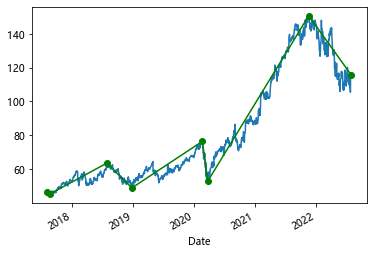

In [18]:
from pandas_datareader import get_data_yahoo

X = get_data_yahoo('GOOG')['Adj Close']
pivots = peak_valley_pivots(X.values, 0.2, -0.2)
ts_pivots = pd.Series(X, index=X.index)
ts_pivots = ts_pivots[pivots != 0]
X.plot()
ts_pivots.plot(style='g-o');
print(zigzag.compute_segment_returns(X, pivots))

In [26]:
zigzag.compute_segment_returns(X.values, pivots)

array([-0.02550544,  0.39890366, -0.23031071,  0.56387908, -0.30790142,
        1.85266219, -0.23375509])